In [1]:
# import data
import pickle
from structs.types import Result

results: list[Result] = []

for i in range(16):
    with open(f"results/{i}.pkl", "rb") as reader:
        results.extend(pickle.load(reader))

In [2]:
# show sample data
print("==========")
print(f"gesture {results[0].gesture1} vs gesture {results[0].gesture2}")
print("----------")
print("location similarity:")
print(f"\tleft hand : {results[0].location_results[0]:.5f}")
print(f"\tright hand: {results[0].location_results[1]:.5f}")
print("motion error:")
print(f"\tleft shoulder : {results[0].motion_results[0]:.5f}")
print(f"\tright shoulder: {results[0].motion_results[1]:.5f}")
print(f"\tleft elbow    : {results[0].motion_results[2]:.5f}")
print(f"\tright elbow   : {results[0].motion_results[3]:.5f}")
print(f"\tleft wrist    : {results[0].motion_results[4]:.5f}")
print(f"\tright wrist   : {results[0].motion_results[5]:.5f}")
print("shape error:")
print(f"\tleft hand : {results[0].shape_results[0]:.5f}")
print(f"\tright hand: {results[0].shape_results[1]:.5f}")

gesture 0 vs gesture 0
----------
location similarity:
	left hand : 1.00000
	right hand: 0.99457
motion error:
	left shoulder : 0.50201
	right shoulder: 0.48968
	left elbow    : 0.50189
	right elbow   : 0.48956
	left wrist    : 0.50183
	right wrist   : 0.43354
shape error:
	left hand : 0.00000
	right hand: 26.82965


# Location Threshold

In [3]:
def testLocation(results: list[Result], threshold: float):
    true_pos = 0
    true_neg = 0
    false_pos = 0
    false_neg = 0

    for result in results:
        if result.gesture1 == result.gesture2:
            if (result.location_results[0] < threshold
                    or result.location_results[1] < threshold):
                false_neg += 1
                continue

            true_pos += 1
            continue

        if (result.location_results[0] < threshold
                or result.location_results[1] < threshold):
            true_neg += 1
            continue

        false_pos += 1

    return true_pos, true_neg, false_pos, false_neg

In [4]:
# sample test
true_pos, true_neg, false_pos, false_neg =  testLocation(results, 0)

print(f"True Positives: {true_pos}")
print(f"True Negatives: {true_neg}")
print(f"False Positives: {false_pos}")
print(f"False Negatives: {false_neg}")

accuracy = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)
precision = (true_pos) / (true_pos + false_pos)
recall = (true_pos) / (true_pos + true_neg)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

True Positives: 240
True Negatives: 0
False Positives: 240
False Negatives: 0
Accuracy: 0.5
Precision: 0.5
Recall: 1.0


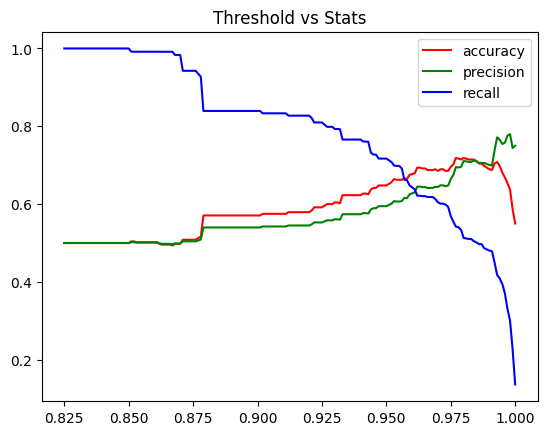

In [5]:
# find optimal threshold
import matplotlib.pyplot as plt
import numpy as np

thresholds = [i / 1000 for i in range(825, 1001)]
accuracies = []
precisions = []
recalls = []

for threshold in thresholds:
    print(f"threshold: {threshold}  ", end="\r")

    true_pos, true_neg, false_pos, false_neg =  testLocation(results, threshold)
    accuracy = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)
    precision = (true_pos) / (true_pos + false_pos)
    recall = (true_pos) / (true_pos + true_neg)

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)


np_thresholds = np.array(thresholds)
np_accuracies = np.array(accuracies)
np_precisions = np.array(precisions)
np_recalls = np.array(recalls)

plt.plot(np_thresholds, np_accuracies, color="r", label="accuracy")
plt.plot(np_thresholds, np_precisions, color="g", label="precision")
plt.plot(np_thresholds, np_recalls, color="b", label="recall")

plt.title("Threshold vs Stats")
plt.legend()
plt.show()